#### **Industrial Anomaly Detection for Capsule Manufacturing Using PatchCore**

#### **Purpose:** This project implements an unsupervised PatchCore model with a ResNet-50 backbone to detect and localize manufacturing defects in capsules.

##### **Source:** MVTec AD Dataset - Capsule Category.

##### **Author:** Bello Oluwatobi

##### **Date:** December 28, 2025

### #1 Importing Libraries

In [ ]:
# importing libraries
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import torch
from torchvision.transforms import transforms
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

### #2 Downloading and extracting the capsule dataset

In [2]:
# downloading the capsule image dataset
import urllib.request
urllib.request.urlretrieve("https://drive.usercontent.google.com/download?id=11WWV4N55HCObd7Y6TXGByCkj16FubryV&export=download&authuser=0&confirm=t", "capsule.tar.xz")

import tarfile

with tarfile.open('capsule.tar.xz') as f:
    f.extractall('.',  filter='data')

### #3 Image transformation and conversion

In [3]:
# generating a transform object for resizing the images to 320x320 pixels and conversion to tensor

# ImageNet-standard normalization values for pre-trained models
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((320,320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

### #4 Loading pretrained Resnet50 Model and extracting features

In [ ]:
# writing a class to load a ResNet50 model to extract and concatenate intermediate feature maps
class Resnet50FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super(Resnet50FeatureExtractor, self).__init__()
        # loading the pre-trained weights and setting them to evaluation mode
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False

        # writing hook function to capture activations at layers 2 and 3
        def hook(module, input, output) -> None:
            """This hook saves the extracted feature map on self.featured."""
            self.features.append(output)
        # attaching the hooks to the final blocks of layer2 and layer3
        self.model.layer2[-1].register_forward_hook(hook)
        self.model.layer3[-1].register_forward_hook(hook)

    def forward(self, input):

        self.features = [] # initialing the features store
        with torch.no_grad():
            _ = self.model(input)

        # processing the feature maps into a unified patch
        self.avg = torch.nn.AvgPool2d(3, stride=1)
        fmap_size = self.features[0].shape[-2]
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)

        # aligning, concatenating, and flattening the feature maps into a column tensor
        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]
        resized_maps[0] = resized_maps[0] * 4
        patch = torch.cat(resized_maps, 1)
        patch = patch.reshape(patch.shape[1], -1).T

        return patch

### #5 Initializing the backbone and generating the memory bank

In [ ]:
# loading a sample image for feature extraction
image = Image.open(r'./capsule/train/good/000.png')
image = transform(image).unsqueeze(0).cuda()

# initializing the backbone and extracting the concatenated feature maps
backbone = Resnet50FeatureExtractor().cuda()
feature = backbone(image)

# displaying the shape i.e. (number of patches and total channel depth
print(feature.shape)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 82.8MB/s]


torch.Size([1600, 1536])


In [ ]:
# generating the memory bank from the "good" capsule image data

# initializing the memory bank storage
memory_bank =[]

# looping through the 'good' training images to build the memory bank
folder_path = Path(r'./capsule/train/good/')

for pth in tqdm(folder_path.iterdir(),leave=False):

    with torch.no_grad():
        data = transform(Image.open(pth)).cuda().unsqueeze(0)
        features = backbone(data)
        memory_bank.append(features.cpu().detach())

# concatenate all image features into a single matrix
memory_bank = torch.cat(memory_bank,dim=0).cuda()

0it [00:00, ?it/s]

In [7]:
# reducing the memory bank size for computational efficiency
SAMPLING_RATIO = 0.1 # 10% sampling ratio
num_samples = int(memory_bank.shape[0] * SAMPLING_RATIO)
# randomly shuffling and selecting a subset of feature vectors
indices = torch.randperm(memory_bank.shape[0])[:num_samples]
memory_bank = memory_bank[indices]

### #6 Generating anomaly scores for the "good" capsule data (K Nearest Neighbours)

In [ ]:
# initializing a list to store anomaly scores for each image
y_score=[]
folder_path = Path(r'./capsule/train/good/')

# looping through each image and calculating its anomaly score
for pth in tqdm(folder_path.iterdir(),leave=False):
    data = transform(Image.open(pth)).cuda().unsqueeze(0)
    with torch.no_grad():
        features = backbone(data)

    distances = torch.cdist(features, memory_bank, p=2.0)
    dist_score, dist_score_idxs = torch.min(distances, dim=1)
    s_star = torch.max(dist_score)
    segm_map = dist_score.view(1, 1, 40, 40)

    y_score.append(s_star.cpu().numpy())

0it [00:00, ?it/s]

### #7 Getting the initial threshold score

38.410982608795166


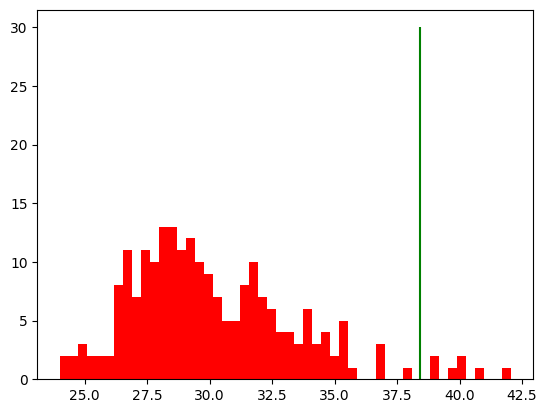

In [9]:
# selecting the threshold using IQR (Interquartile Range)
q1, q3 = np.percentile(y_score, [25, 75])
iqr = q3 - q1
iqr_threshold = q3 + (1.5 * iqr)

print(iqr_threshold)

# visualizing the threshold score with the histogram plot of the anomaly scores
plt.hist(y_score,bins=50, color='r')
plt.vlines(x=iqr_threshold,ymin=0,ymax=30,color='g')
plt.show()

### #8 Examining "defect" test image data (model evaluation)

In [ ]:
y_score = [] # storing the predicted anomaly score
y_true=[] # storing the ground truth i.e. 0 for good and 1 for defect

# looping through all test folders
for classes in ['crack','faulty_imprint','good','poke','scratch','squeeze']:
    folder_path = Path(r'./capsule/test/{}'.format(classes))

    for pth in tqdm(folder_path.iterdir(),leave=False):
        # extracing label based on folder name
        class_label = pth.parts[-2]
        with torch.no_grad():
            test_image = transform(Image.open(pth)).cuda().unsqueeze(0)
            features = backbone(test_image)

        # calculating the anomaly scores
        distances = torch.cdist(features, memory_bank, p=2.0)
        dist_score, dist_score_idxs = torch.min(distances, dim=1)
        s_star = torch.max(dist_score)
        segm_map = dist_score.view(1, 1, 40, 40)

        # recording the prediction score and the ground truth label
        y_score.append(s_star.cpu().numpy())
        y_true.append(0 if class_label == 'good' else 1)



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

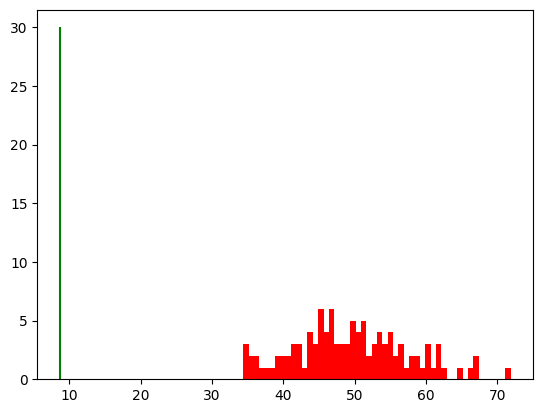

In [11]:
# visualizing the y_score values which belong to the defect classes

y_score_defect = [score  for score,true in zip(y_score,y_true) if true==1]
plt.hist(y_score_defect,bins=50, color='r')
plt.vlines(x=8.7,ymin=0,ymax=30,color='g')
plt.show()

### #9 Model Performance Metrics

AUC-ROC Score: 0.9904268049461508


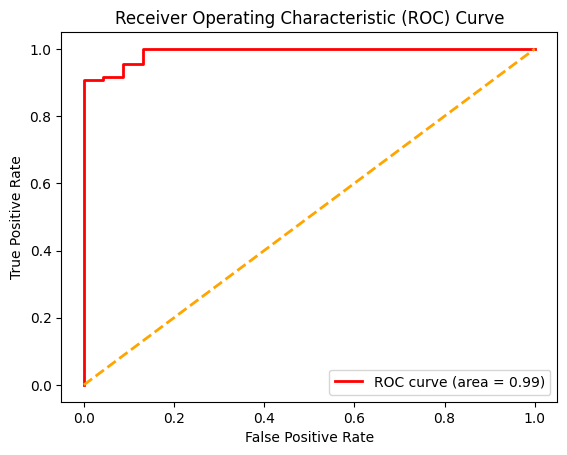

best_threshold = 34.391998291015625


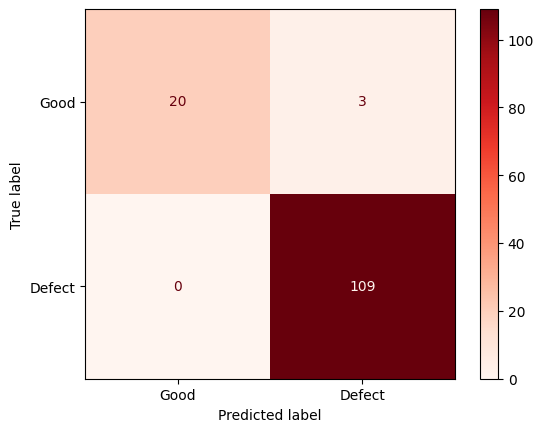

In [12]:
# importing performance metrics libraries
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score


# calculating the AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# calculating the F1 scores
f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]

# Select the best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'best_threshold = {best_threshold}')

# generating the confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Good','Defect'])
disp.plot(cmap='Reds')
plt.show()

### #10 Visualizing the anomaly detection process on the test data

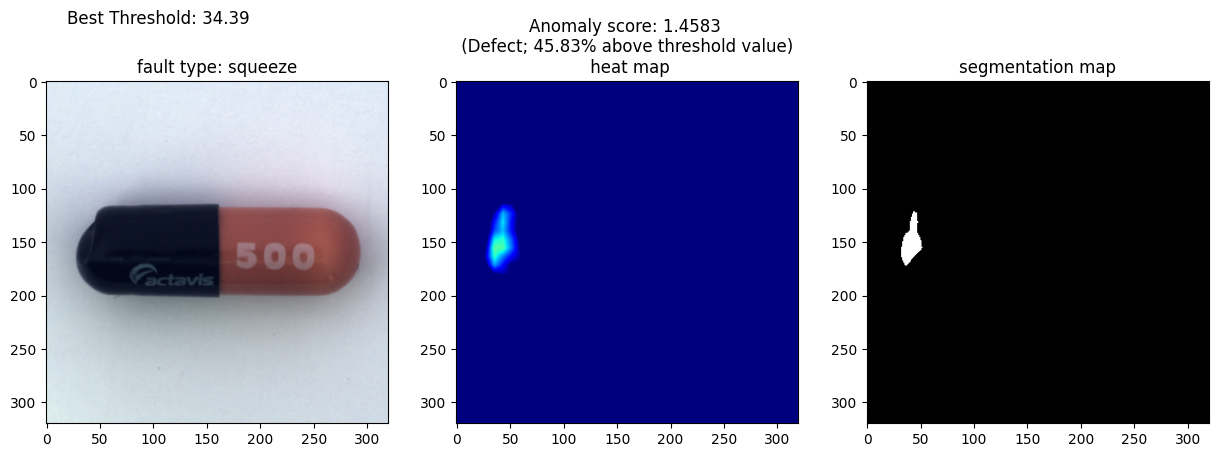

In [ ]:
# importing the required libraries
import time
from IPython.display import clear_output

# setting the model to evaluation mode
backbone.eval()

# specifying the test images path
test_path = Path('./capsule/test/')

# looping through all the images in all the test subfolders
for path in test_path.glob('*/*.png'):

  # extracting the defect types as labels
  fault_type = path.parts[-2]

  # processing only one specific defect type at once
  if fault_type in ['squeeze']:
     # processing the image
    test_image = transform(Image.open(path)).cuda().unsqueeze(0)

    # extracting the features and computing the anomaly score
    with torch.no_grad():
      features = backbone(test_image)

      distances = torch.cdist(features, memory_bank, p=2.0)
      dist_score, dist_score_idxs = torch.min(distances, dim=1)
      s_star = torch.max(dist_score)

      # creating the heatmap
      segm_map = dist_score.view(1, 1, 40, 40)
      segm_map = torch.nn.functional.interpolate(
                    segm_map,
                    size=(320, 320),
                    mode='bilinear'
                ).cpu().squeeze().numpy()

      # generating the anomaly score and classifying image as good or defect
      y_score_image = s_star.cpu().numpy()
      y_pred_image = 1*(y_score_image >= best_threshold)

      anomaly_score = y_score_image / best_threshold

      if anomaly_score >= 1:
        percent = f'{((anomaly_score - 1) * 100):.2f}% above threshold value'
      else:
        percent = f'{((1 - anomaly_score) * 100):.2f}% below threshold value'

      class_label = ['Good','Defect']


      # visualizing the results
      plt.figure(figsize=(15,5))

      plt.suptitle(f'Best Threshold: {best_threshold:.2f}', x=0.2)


      plt.subplot(1,3,1)
      img_to_show = test_image.squeeze().permute(1,2,0).cpu().numpy()
      # rescaling to [0, 1] range for visualization
      img_to_show = (img_to_show - img_to_show.min()) / (img_to_show.max() - img_to_show.min())
      plt.imshow(img_to_show)
      plt.title(f'fault type: {fault_type}')

      plt.subplot(1,3,2)
      heat_map = segm_map
      plt.imshow(heat_map, cmap='jet',vmin=best_threshold, vmax=best_threshold*2)
      plt.title(f'Anomaly score: {y_score_image / best_threshold:0.4f} \n ({class_label[y_pred_image]}; {percent}) \n heat map')

      plt.subplot(1,3,3)
      plt.imshow((heat_map > best_threshold*1.25), cmap='gray')
      plt.title(f'segmentation map')

      plt.show()

      time.sleep(0.05)
      clear_output(wait=True)

In [15]:
# storing the memory bank and best threshold value in a single file
checkpoint = {
    'memory_bank': memory_bank.cpu(),
    'threshold': best_threshold,
}

torch.save(checkpoint, 'capsule_patchcore_assets.pt')